In [ ]:
# 1. Import Necessary Libraries
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import cv2

In [53]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = '/content/drive/MyDrive/flower_dataset'

In [ ]:
import os

print("Folder tersedia:", os.path.exists(data_dir))
print("Isi folder:", os.listdir(data_dir))

Folder tersedia: True
Isi folder: ['val', 'train', 'test', '.ipynb_checkpoints']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
print(f"Jumlah data train: {len(train_dataset)}")
print(f"Kelas: {train_dataset.classes}")

Jumlah data train: 768
Kelas: ['anggrek_kalajengking', 'kamboja_merah_muda', 'kamboja_putih', 'lily']


In [ ]:
# 2. Load and Transform Data
data_dir = "/content/drive/MyDrive/flower_dataset"
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

In [ ]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
print(f"Jumlah data train: {len(train_data)}")
print(f"Jumlah data validasi: {len(val_data)}")
print(f"Jumlah data test: {len(test_data)}")
print(f"Daftar kelas: {train_data.classes}")

Jumlah data train: 768
Jumlah data validasi: 192
Jumlah data test: 240
Daftar kelas: ['anggrek_kalajengking', 'kamboja_merah_muda', 'kamboja_putih', 'lily']


In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

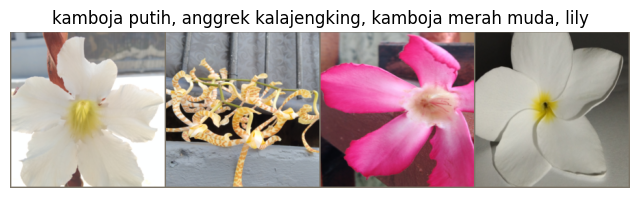

In [ ]:
# 4. Visualizing Images from the Dataset
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu batch gambar
inputs, labels = next(iter(train_loader))
class_names = ['anggrek kalajengking', 'kamboja merah muda', 'kamboja putih', 'lily']

# Simpan satu gambar per kelas unik
seen_classes = set()
selected_imgs = []
selected_labels = []

for img, lbl in zip(inputs, labels):
    if lbl.item() not in seen_classes:
        seen_classes.add(lbl.item())
        selected_imgs.append(img)
        selected_labels.append(lbl.item())
    if len(seen_classes) == 4:
        break

# Buat grid dan tampilkan
out = torchvision.utils.make_grid(selected_imgs)
imshow(out, title=", ".join([class_names[i] for i in selected_labels]))

In [ ]:
# 5. Computing Error Rate Analysis (as a function)
def compute_error_rate(preds, labels):
    return 1 - (preds == labels).sum().item() / len(labels)

In [ ]:
# 6. Data Preprocessing (already included in transforms)

In [31]:
# 7. Training the Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze feature extractor

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.classes))  # Custom output
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Epoch 1/50 | Train Loss: 0.7483 | Val Loss: 0.2645
Epoch 2/50 | Train Loss: 0.2072 | Val Loss: 0.0832
Epoch 3/50 | Train Loss: 0.1154 | Val Loss: 0.0484
Epoch 4/50 | Train Loss: 0.0838 | Val Loss: 0.0317
Epoch 5/50 | Train Loss: 0.0643 | Val Loss: 0.0233
Epoch 6/50 | Train Loss: 0.0490 | Val Loss: 0.0186
Epoch 7/50 | Train Loss: 0.0417 | Val Loss: 0.0154
Epoch 8/50 | Train Loss: 0.0378 | Val Loss: 0.0124
Epoch 9/50 | Train Loss: 0.0389 | Val Loss: 0.0104
Epoch 10/50 | Train Loss: 0.0269 | Val Loss: 0.0086
Epoch 11/50 | Train Loss: 0.0339 | Val Loss: 0.0097
Epoch 12/50 | Train Loss: 0.0222 | Val Loss: 0.0068
Epoch 13/50 | Train Loss: 0.0214 | Val Loss: 0.0069
Epoch 14/50 | Train Loss: 0.0239 | Val Loss: 0.0057
Epoch 15/50 | Train Loss: 0.0157 | Val Loss: 0.0054
Epoch 16/50 | Train Loss: 0.0179 | Val Loss: 0.0048
Epoch 17/50 | Train Loss: 0.0206 | Val Loss: 0.0036
Epoch 18/50 | Train Loss: 0.0143 | Val Loss: 0.0040
Epoch 19/50 | Train Loss: 0.0134 | Val Loss: 0.0035
Epoch 20/50 | Train L

In [71]:
import torch
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=test_data.classes))

                      precision    recall  f1-score   support

anggrek_kalajengking       1.00      1.00      1.00        60
  kamboja_merah_muda       1.00      1.00      1.00        60
       kamboja_putih       1.00      1.00      1.00        60
                lily       1.00      1.00      1.00        60

            accuracy                           1.00       240
           macro avg       1.00      1.00      1.00       240
        weighted avg       1.00      1.00      1.00       240



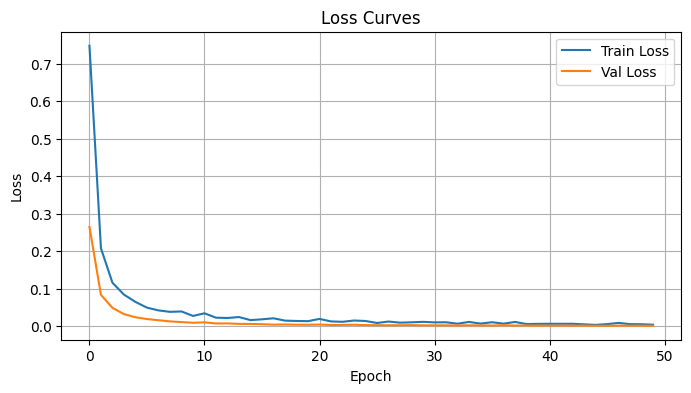

In [72]:
# 9. Visualizing Loss Curves
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

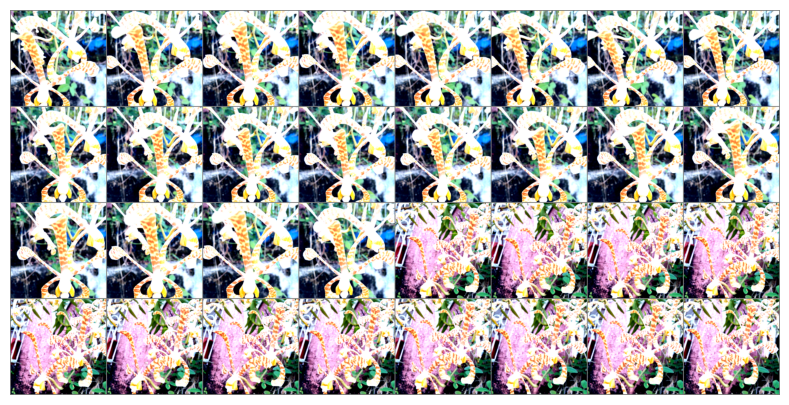

Predicted: ['anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking', 'anggrek kalajengking']


In [73]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Pastikan model dan device sudah didefinisikan
model.eval()

# Ambil satu batch dari test_loader
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device)

# Prediksi tanpa mengaktifkan gradient
with torch.no_grad():
    outputs = model(sample_images)
    _, preds = torch.max(outputs, 1)

# Tampilkan gambar-gambar dan prediksinya
def imshow(img):
    img = img / 2 + 0.5  # unnormalize jika datanya dinormalisasi
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Tampilkan gambar dan hasil prediksi
imshow(make_grid(sample_images.cpu()))
print("Predicted:", [class_names[pred] for pred in preds.cpu()])

In [74]:
# Grad-CAM Visualization
import torchvision.models as models
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torchvision.utils import save_image

def generate_gradcam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.layer4[2].conv3
    final_conv.register_forward_hook(forward_hook)
    final_conv.register_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]
    activations_val = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(activations_val.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations_val[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

In [75]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import resize
from PIL import Image

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    grads = gradients[0].cpu().detach()
    acts = activations[0].cpu().detach()
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * acts, dim=1).squeeze()
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    cam = np.uint8(255 * cam.numpy())
    cam_img = Image.fromarray(cam)
    cam_resized = resize(cam_img, [input_tensor.shape[2], input_tensor.shape[3]])
    cam_resized = np.array(cam_resized) / 255.0

    forward_handle.remove()
    backward_handle.remove()

    return cam_resized

def visualize_gradcam(model, test_dataset, index, class_names, device):
    img, label = test_dataset[index]
    input_tensor = img.unsqueeze(0).to(device)
    target_layer = model.layer4[-1]
    cam = generate_gradcam(model, input_tensor, label, target_layer)

    img_np = img.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np